# Importation des librairies

In [56]:
import os
import sys

sys.path.append("..")

# Basic Libraries
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
# Visualization Libraries

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from settings import (
    PROJECT_PATH,
    REGRESSION_TARGET,
    CLASSIFICATION_TARGET)

In [57]:
import warnings
warnings.filterwarnings('ignore')

# Importation du fichier

In [58]:
table= pq.read_table(os.path.join(PROJECT_PATH,'data/raw/transactions_immobilieres.parquet'))
# Convertir en DataFrame Pandas
data = table.to_pandas()

data.head()

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,annee_transaction,prix_m2,prix_m2_moyen,nb_transactions_mois,en_dessous_du_marche,code_departement,nom_departement,code_region,nom_region,region
0,83094,2018-01-03,98000.0,1,53,BOURG-EN-BRESSE,1000,8 RUE TRAVERSIERE,Appartement,0,...,2018,1400.000000,1229.764459,17,0,01,Ain,84,Auvergne-Rhône-Alpes,84
1,70798,2018-01-04,225000.0,1,143,DIVONNE-LES-BAINS,1220,62 RUE VOLTAIRE,Appartement,0,...,2018,4017.857143,4512.419826,9,1,01,Ain,84,Auvergne-Rhône-Alpes,84
2,77488,2018-01-04,67000.0,1,53,BOURG-EN-BRESSE,1000,12 ALL DE LA PETITE REYSSOUZE,Appartement,0,...,2018,1488.888889,1229.764459,17,0,01,Ain,84,Auvergne-Rhône-Alpes,84
3,78665,2018-01-05,503000.0,1,143,DIVONNE-LES-BAINS,1220,48 RUE DE LA SCIE,Appartement,0,...,2018,6134.146341,4512.419826,9,0,01,Ain,84,Auvergne-Rhône-Alpes,84
4,72218,2018-01-05,339000.0,1,143,DIVONNE-LES-BAINS,1220,151 CHE DE LA CREUSE,Appartement,0,...,2018,4985.294118,4512.419826,9,0,01,Ain,84,Auvergne-Rhône-Alpes,84


In [59]:
df= data.copy()

# Feature Enginering sur la localisation

In [60]:
# regrouper par ville

df_city = df.copy()
df_city = df_city.groupby(['nom_departement','ville','annee_transaction', 'mois_transaction',
                           'nb_transactions_mois'] ).agg(prix_m2_moyen=('prix_m2_moyen', 'mean')).round(2).reset_index()
df_city

,nom_departement,ville,annee_transaction,mois_transaction,nb_transactions_mois,prix_m2_moyen
0,Ain,AMBERIEU-EN-BUGEY,2019,7,5,1488.16
1,Ain,AMBERIEU-EN-BUGEY,2019,10,8,1742.17
2,Ain,AMBERIEU-EN-BUGEY,2019,12,8,1525.69
3,Ain,AMBERIEU-EN-BUGEY,2020,2,5,1662.49
4,Ain,AMBERIEU-EN-BUGEY,2020,11,5,1757.71
...,...,...,...,...,...,...
24484,Yvelines,VIROFLAY,2021,4,8,5786.16
24485,Yvelines,VIROFLAY,2021,5,10,5881.62
24486,Yvelines,VIROFLAY,2021,6,6,5277.27
24487,Yvelines,VIROFLAY,2021,10,5,6300.86


### Recherche des villes en tension

In [61]:
def compute_city_features(
    transaction_per_city: pd.DataFrame,
    aggregation_columns: list = ['nom_departement', 'ville', 'annee_transaction', 'mois_transaction', 'nb_transactions_mois'],
    threshold: float = 0.8
):
    """
    Cette fonction calcule plusieurs caractéristiques liées aux transactions immobilières par ville.

    1. Elle agrège les données de transactions par ville et mois pour obtenir le prix moyen au m2.
    2. Elle calcule le ratio des transactions de chaque ville par rapport au département.
    3. Elle applique un seuil basé sur le quantile spécifié pour identifier les villes en tension.

    Paramètres :
    -----------
    transaction_per_city : pd.DataFrame
        Un DataFrame contenant les informations des transactions immobilières, y compris le prix au m2,
        le nombre de transactions, ainsi que des colonnes de regroupement par département, ville et mois.

    aggregation_columns : list, optionnel
        Liste des colonnes utilisées pour l'agrégation des données (par défaut : ['nom_departement', 'ville', 'annee_transaction', 'mois_transaction', 'nb_transactions_mois']).

    threshold : float, optionnel
        Quantile (par défaut à 0.8) utilisé pour déterminer le seuil au-dessus duquel une ville est considérée en tension.

    Retour :
    --------
    pd.DataFrame
        Un DataFrame enrichi avec :
        - `prix_m2_moyen` : Prix moyen au m2 par ville et mois,
        - `ratio_transaction` : Ratio des transactions de la ville par rapport au département,
        - `ville_demandee` : Indicateur binaire indiquant si la ville est en tension (1 si en tension, 0 sinon).
    """

    # Agréger les données par ville, année, mois et nombre de transactions
    transaction_per_city = transaction_per_city.groupby(aggregation_columns).agg(prix_m2_moyen=('prix_m2_moyen', 'mean')).reset_index()

    # Calculer le nombre total de transactions par département et par mois
    nb_transactions_departement = transaction_per_city.groupby(['nom_departement', 'annee_transaction', 'mois_transaction'])['nb_transactions_mois'].sum().reset_index().rename(columns={'nb_transactions_mois': 'nb_transactions_departement'})

    # Fusionner les données pour avoir le nombre total de transactions par département pour chaque ligne de ville
    transaction_per_city = transaction_per_city.merge(nb_transactions_departement, on=['nom_departement', 'annee_transaction', 'mois_transaction'], how='outer')

    # Calculer le ratio des transactions de la ville par rapport au département
    transaction_per_city['ratio_transaction'] = (transaction_per_city['nb_transactions_mois'] / transaction_per_city['nb_transactions_departement']) * 100

    # Déterminer le seuil de tension en fonction du quantile spécifié
    seuil_tension = transaction_per_city['ratio_transaction'].quantile(threshold)

    # Appliquer un indicateur binaire pour savoir si la ville est en tension
    transaction_per_city['ville_demandee'] = transaction_per_city['ratio_transaction'].apply(lambda x: 1 if x > seuil_tension else 0)

    return transaction_per_city



In [62]:
df_city=compute_city_features (
    transaction_per_city = df_city,
    aggregation_columns = ['nom_departement','ville','annee_transaction', 'mois_transaction',
                           'nb_transactions_mois'],
    threshold =0.8
)

In [63]:
df_city['ville_demandee'].describe()

count    24489.000000
mean         0.200008
std          0.400014
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: ville_demandee, dtype: float64

### Lagging pour eviter le data leakage

In [64]:
def compute_features_price_per_m2(
    average_per_month_per_city: pd.DataFrame,
    sort_columns: list = [
        "nom_departement",
        "ville",
        "annee_transaction",
        "mois_transaction"
    ],
    aggregation_columns: list = [
        "nom_departement",
        "ville",
        "id_ville",
    ],
    aggregation_months: int = 6
):
    """
    Cette fonction calcule des caractéristiques dérivées pour les prix au m² et le nombre de transactions
    pour chaque ville et département, avec des moyennes mobiles et des valeurs précédentes.

    Paramètres:
    - average_per_month_per_city (pd.DataFrame): DataFrame contenant les données des prix au m²
      et des transactions par mois et ville.
    - sort_columns (list, optionnel): Liste des colonnes par lesquelles trier les données avant de
      calculer les caractéristiques dérivées. Par défaut, cela inclut "nom_departement", "ville", "annee_transaction",
      et "mois_transaction".
    - aggregation_columns (list, optionnel): Colonnes utilisées pour le groupby. Par défaut, cela inclut
      "nom_departement", "ville" et "id_ville".
    - aggregation_months (int, optionnel): Nombre de mois pour la moyenne mobile glissante. Par défaut, c'est 6.

    Retour:
    - pd.DataFrame: DataFrame avec les nouvelles caractéristiques dérivées, incluant les prix et
      le nombre de transactions des mois précédents, ainsi que les moyennes mobiles.

    Processus:
    1. Trie les données selon les colonnes spécifiées.
    2. Calcule les prix au m² et le nombre de transactions des mois précédents pour chaque groupe.
    3. Calcule les moyennes mobiles glissantes pour les prix au m² et les transactions.
    4. Supprime les lignes contenant des valeurs manquantes (NaN).
    5. Renomme la colonne de la moyenne mobile pour refléter le nombre de mois utilisé.
    """

    # Trier les données selon les colonnes spécifiées
    average_per_month_per_city = average_per_month_per_city.sort_values(by=sort_columns)

    # Calculer les colonnes dérivées pour le mois précédent (shift)
    average_per_month_per_city["prix_m2_moyen_mois_precedent"] = (
        average_per_month_per_city.groupby(aggregation_columns)["prix_m2_moyen"]
        .shift()
    )
    average_per_month_per_city["nb_transactions_mois_precedent"] = (
        average_per_month_per_city.groupby(aggregation_columns)['nb_transactions_mois']
        .shift()
    )

    # Calculer les moyennes mobiles glissantes sur 'aggregation_months' mois
    average_per_month_per_city["prix_m2_moyen_glissant"] = (
        average_per_month_per_city.groupby(aggregation_columns)["prix_m2_moyen"]
        .transform(lambda x: x.rolling(window=aggregation_months).mean())
    )
    average_per_month_per_city["nb_transaction_moyen_glissant"] = (
        average_per_month_per_city.groupby(aggregation_columns)['nb_transactions_mois']
        .transform(lambda x: x.rolling(window=aggregation_months).mean())
    )

    # Supprimer les lignes contenant des NaN après shift et rolling
    average_per_month_per_city = average_per_month_per_city.dropna()

    # Renommer la colonne de moyenne mobile pour refléter le nombre de mois dans la moyenne glissante
    average_per_month_per_city = average_per_month_per_city.rename(
        columns={
            "nb_transaction_moyen_glissant": f"nb_transaction_moyen_glissant_{aggregation_months}",
            "prix_m2_moyen_glissant": f"prix_m2_moyen_glissant_{aggregation_months}"
        }
    )

    # Retourner le DataFrame avec les nouvelles caractéristiques calculées
    return average_per_month_per_city


In [65]:
df_city = compute_features_price_per_m2(
    df_city,
    sort_columns=[
        "nom_departement",
        "ville",
        "annee_transaction",
        "mois_transaction",
    ],
    aggregation_columns=[
        "nom_departement",
        "ville"
    ],
    aggregation_months=6)

In [66]:
transactions = pd.merge( df, df_city,
                        on=  ["nom_departement",
        "ville",
        "annee_transaction",
        "mois_transaction",
        "prix_m2_moyen",
        "nb_transactions_mois"],
        how='inner',
        )


In [67]:
transactions.head()

,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,type_batiment,vefa,...,code_region,nom_region,region,nb_transactions_departement,ratio_transaction,ville_demandee,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,prix_m2_moyen_glissant_6,nb_transaction_moyen_glissant_6
0,3898364,2020-05-05,159000.0,34,192,PALAVAS-LES-FLOTS,34250,9490 RUE DES SAINTES MARIES,Appartement,0,...,76,Occitanie,76,314,1.592357,0,3955.83,11.0,4147.105,9.833333
1,3904739,2020-05-18,120300.0,34,192,PALAVAS-LES-FLOTS,34250,9 RUE SUBSTANTION,Appartement,0,...,76,Occitanie,76,314,1.592357,0,3955.83,11.0,4147.105,9.833333
2,3901893,2020-05-19,107000.0,34,192,PALAVAS-LES-FLOTS,34250,745 AV EVECHE DE MAGUELONNE,Appartement,0,...,76,Occitanie,76,314,1.592357,0,3955.83,11.0,4147.105,9.833333
3,3894858,2020-05-27,158000.0,34,192,PALAVAS-LES-FLOTS,34250,7 BD MARECHAL FOCH,Appartement,0,...,76,Occitanie,76,314,1.592357,0,3955.83,11.0,4147.105,9.833333
4,3881273,2020-05-27,180000.0,34,192,PALAVAS-LES-FLOTS,34250,6 RUE DU PONANT,Appartement,0,...,76,Occitanie,76,314,1.592357,0,3955.83,11.0,4147.105,9.833333


In [68]:
transactions.columns

Index(['id_transaction', 'date_transaction', 'prix', 'departement', 'id_ville',
       'ville', 'code_postal', 'adresse', 'type_batiment', 'vefa', 'n_pieces',
       'surface_habitable', 'id_parcelle_cadastre', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2', 'prix_m2_moyen',
       'nb_transactions_mois', 'en_dessous_du_marche', 'code_departement',
       'nom_departement', 'code_region', 'nom_region', 'region',
       'nb_transactions_departement', 'ratio_transaction', 'ville_demandee',
       'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent',
       'prix_m2_moyen_glissant_6', 'nb_transaction_moyen_glissant_6'],
      dtype='object')

### One-Hot-Encoding

## 

In [69]:
from typing import Tuple, Dict

def encode_column(df: pd.DataFrame, column: str) -> Tuple[pd.DataFrame, Dict[str, OneHotEncoder]]:
    """
    Encode une colonne spécifique avec OneHotEncoder et retourne des valeurs binaires.

    Args:
        df (pd.DataFrame): DataFrame d'entrée.
        column (str): Nom de la colonne à encoder.

    Returns:
        Tuple[pd.DataFrame, Dict[str, OneHotEncoder]]:
        - DataFrame avec la colonne encodée en valeurs binaires (0, 1).
        - Dictionnaire contenant la colonne et son encodeur.
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    # Fit and transform the column
    encoded = encoder.fit_transform(df[[column]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([column]), index=df.index)

    # Convertir les float en int
    encoded_df = encoded_df.astype(int)

    # Ajouter les colonnes encodées et supprimer la colonne d'origine
    df = pd.concat([df.drop(columns=[column]), encoded_df], axis=1)

    # Return the modified DataFrame and a dictionary mapping the column to its encoder
    return df, {column: encoder}



In [70]:
# Appliquer l'encodage et assigner le résultat à la variable transactions
transactions, encoder_type_batiment = encode_column(transactions, 'type_batiment')
transactions, encoder_nom_region = encode_column(transactions, 'nom_region')

transactions.head()


,id_transaction,date_transaction,prix,departement,id_ville,ville,code_postal,adresse,vefa,n_pieces,...,ratio_transaction,ville_demandee,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,prix_m2_moyen_glissant_6,nb_transaction_moyen_glissant_6,type_batiment_Maison,nom_region_Occitanie,nom_region_Provence-Alpes-Côte d'Azur,nom_region_Île-de-France
0,3898364,2020-05-05,159000.0,34,192,PALAVAS-LES-FLOTS,34250,9490 RUE DES SAINTES MARIES,0,2,...,1.592357,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
1,3904739,2020-05-18,120300.0,34,192,PALAVAS-LES-FLOTS,34250,9 RUE SUBSTANTION,0,2,...,1.592357,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
2,3901893,2020-05-19,107000.0,34,192,PALAVAS-LES-FLOTS,34250,745 AV EVECHE DE MAGUELONNE,0,1,...,1.592357,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
3,3894858,2020-05-27,158000.0,34,192,PALAVAS-LES-FLOTS,34250,7 BD MARECHAL FOCH,0,2,...,1.592357,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
4,3881273,2020-05-27,180000.0,34,192,PALAVAS-LES-FLOTS,34250,6 RUE DU PONANT,0,2,...,1.592357,0,3955.83,11.0,4147.105,9.833333,0,1,0,0


## Analyse des corrélations entre features numériques

In [71]:
transactions.columns

Index(['id_transaction', 'date_transaction', 'prix', 'departement', 'id_ville',
       'ville', 'code_postal', 'adresse', 'vefa', 'n_pieces',
       'surface_habitable', 'id_parcelle_cadastre', 'latitude', 'longitude',
       'mois_transaction', 'annee_transaction', 'prix_m2', 'prix_m2_moyen',
       'nb_transactions_mois', 'en_dessous_du_marche', 'code_departement',
       'nom_departement', 'code_region', 'region',
       'nb_transactions_departement', 'ratio_transaction', 'ville_demandee',
       'prix_m2_moyen_mois_precedent', 'nb_transactions_mois_precedent',
       'prix_m2_moyen_glissant_6', 'nb_transaction_moyen_glissant_6',
       'type_batiment_Maison', 'nom_region_Occitanie',
       'nom_region_Provence-Alpes-Côte d'Azur', 'nom_region_Île-de-France'],
      dtype='object')

In [72]:
# colonnes à laisser de côté
cols_extra_info = ['id_transaction', 'date_transaction', 'id_ville', 'ville',
                   'code_departement', 'departement', 'code_region', 'region',
                   'adresse', 'code_postal', 'id_parcelle_cadastre',
                   'prix_m2', 'prix_m2_moyen', 'nom_departement','nb_transactions_mois','ratio_transaction']


In [73]:
transactions=transactions.drop(cols_extra_info,axis=1)
transactions.head()

,prix,vefa,n_pieces,surface_habitable,latitude,longitude,mois_transaction,annee_transaction,en_dessous_du_marche,nb_transactions_departement,ville_demandee,prix_m2_moyen_mois_precedent,nb_transactions_mois_precedent,prix_m2_moyen_glissant_6,nb_transaction_moyen_glissant_6,type_batiment_Maison,nom_region_Occitanie,nom_region_Provence-Alpes-Côte d'Azur,nom_region_Île-de-France
0,159000.0,0,2,35,43.529688,3.936712,5,2020,0,314,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
1,120300.0,0,2,35,43.527431,3.929173,5,2020,1,314,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
2,107000.0,0,1,25,43.522527,3.919305,5,2020,0,314,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
3,158000.0,0,2,32,43.526564,3.930364,5,2020,0,314,0,3955.83,11.0,4147.105,9.833333,0,1,0,0
4,180000.0,0,2,45,43.530175,3.925215,5,2020,0,314,0,3955.83,11.0,4147.105,9.833333,0,1,0,0


In [74]:
X=transactions.drop([CLASSIFICATION_TARGET,REGRESSION_TARGET],axis=1)
y_regression = transactions[REGRESSION_TARGET]
y_classification = transactions[CLASSIFICATION_TARGET]

In [75]:
features_name = X.columns

In [76]:
numerical_features = [
    col for col in X[features_name].select_dtypes(include=['float', 'int']).columns
    if col not in ['vefa', 'ville_demandee'] and not (col.startswith('nom_region') or col.startswith('type'))
]

numerical_features

['n_pieces',
 'surface_habitable',
 'latitude',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent',
 'prix_m2_moyen_glissant_6',
 'nb_transaction_moyen_glissant_6']

In [77]:
categorial_features = [col for col in features_name if col not in numerical_features]
categorial_features

['vefa',
 'nb_transactions_departement',
 'ville_demandee',
 'type_batiment_Maison',
 'nom_region_Occitanie',
 "nom_region_Provence-Alpes-Côte d'Azur",
 'nom_region_Île-de-France']

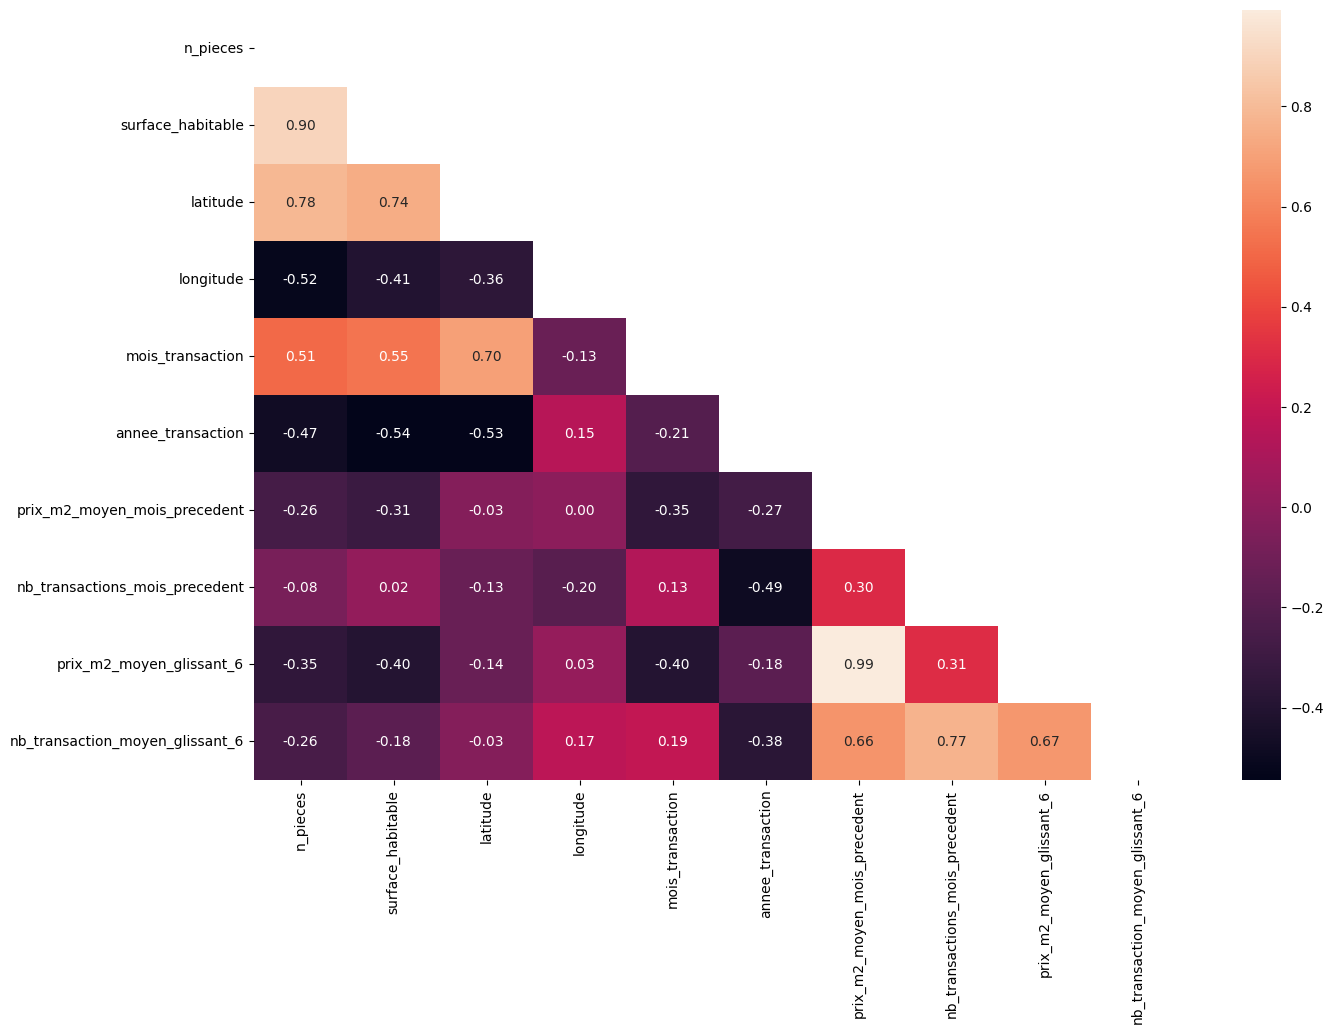

In [78]:
# matrice de corrélation

correlation_matrix= X[numerical_features].corr()
mask= np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt= '.2f')
plt.show()


## Analyse de la matrice de corrélation

On considère comme fortement corrélée les features ayant une corrélation > 0.7.

C'est le cas de :

- 'n_pieces' avec 'latitude' et 'surface_habitable'
-  'surface_habitable' et 'latitude'
- 'latitude' avec 'mois_transaction'
- 'nb_transactions_mois_precedent' avec 'nb_transaction_moyen_glissant_6'
- 'prix_m2_moyen_glissant' avec 'prix_m2_moyen_mois_precedent_6'

Ces corélations indiquent que le prix au m2 et le nombre de transactions évoluent peu sur 6 mois.
parmi les variables corrélée, on choisi de conserver la surface habitable et les features concernant le mois précédent.

In [79]:
highly_correlated_features = ['n_pieces', 'prix_m2_moyen_glissant_6',
 'nb_transaction_moyen_glissant_6', 'latitude']

In [80]:
features_name = [ col for col in features_name if col not in highly_correlated_features]

In [81]:
numerical_features = [col for col in numerical_features if col in features_name]
numerical_features

['surface_habitable',
 'longitude',
 'mois_transaction',
 'annee_transaction',
 'prix_m2_moyen_mois_precedent',
 'nb_transactions_mois_precedent']

### Sauvegarde de numerical_features et features_name

In [86]:
import json

features_name_path= os.path.join('../preprocessing/features_used','features_name.json')
numerical_features_path= os.path.join('../preprocessing/features_used','numerical_features.json')
with open (features_name_path, "w") as f :
    json.dump(features_name,f,indent=4)
with open(numerical_features_path, "w") as f :
    json.dump(numerical_features, f, indent=4)
print("Fichiers JSON sauvegardés avec succès dans 'features_used' !")

Fichiers JSON sauvegardés avec succès dans 'features_used' !


# Sauvegarde du df et des encodeurs

In [177]:
transactions.to_parquet(
    os.path.join(PROJECT_PATH, "data/interim/transactions_post_feature_engineering.parquet")
)


In [178]:
# Définir le chemin du dossier
folder_path = os.path.join(PROJECT_PATH, 'preprocessing/encoders')

# Créer le dossier, y compris tous les répertoires parents si nécessaires
os.makedirs(folder_path, exist_ok=True)



In [179]:
import joblib


# Sauvegarde de l'encodeur dans le répertoire 'preprocessing/encoders/'
encoder_path = os.path.join(PROJECT_PATH, 'preprocessing/encoders/type_batiment_encoder.joblib')

joblib.dump(encoder_type_batiment, encoder_path)


['/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/preprocessing/encoders/type_batiment_encoder.joblib']

In [180]:
# Sauvegarde de l'encodeur dans le répertoire 'preprocessing/encoders/'
encoder_path = os.path.join(PROJECT_PATH, 'preprocessing/encoders/nom_region_encoder.joblib')

joblib.dump(encoder_nom_region, encoder_path)

['/mnt/c/Users/mrgxl/Documents/cours françois/exercice python/Machine Learning/prediction_donnees_immobilieres/preprocessing/encoders/nom_region_encoder.joblib']